# Read all the NASA SMAP HDF5 data for 2015-2016 over Colorado
### This is done separately because the files are many and takes up huge computation time that performing any further code takes forever! 
### Export as a netcdf4 file

In [62]:
import os
from glob import glob

import earthpy as et
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import h5py

In [43]:
data_dir = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data', 'capstone', 'smap_colorado')
file = sorted(glob(os.path.join(data_dir, '*.h5')))

# data_dir = os.path.join(et.io.HOME,
#                         'earth-analytics',
#                         'data', 'capstone', 'smap_l3_new')
# file = sorted(glob(os.path.join(data_dir, '*.h5')))


f = h5py.File(file[0], 'r')
print(file[0])

/Users/jwitte/earth-analytics/data/capstone/smap_colorado/SMAP_L3_SM_P_E_20150331_R17000_002.h5


In [44]:
print("Now lets look at the groups within the file to access:")
i=0;
for key in f.keys():
    print(str(i)+ '\t'+key)
    i+=1
print('\n')

# Lets focus on the AM overpass for this example
group_id=list(f.keys())[1]; 

i=0
print("Now lets look at the variables within the filegroup **Soil_Moisture_Retrieval_Data_AM** to access the actual data:")
for var in list(f[group_id].keys()):
    print(str(i)+'\t'+var)
    i+=1

Now lets look at the groups within the file to access:
0	Metadata
1	Soil_Moisture_Retrieval_Data_AM
2	Soil_Moisture_Retrieval_Data_PM


Now lets look at the variables within the filegroup **Soil_Moisture_Retrieval_Data_AM** to access the actual data:
0	EASE_column_index
1	EASE_row_index
2	albedo
3	albedo_dca
4	albedo_scah
5	albedo_scav
6	boresight_incidence
7	bulk_density
8	clay_fraction
9	freeze_thaw_fraction
10	grid_surface_status
11	latitude
12	latitude_centroid
13	longitude
14	longitude_centroid
15	radar_water_body_fraction
16	retrieval_qual_flag
17	retrieval_qual_flag_dca
18	retrieval_qual_flag_scah
19	retrieval_qual_flag_scav
20	roughness_coefficient
21	roughness_coefficient_dca
22	roughness_coefficient_scah
23	roughness_coefficient_scav
24	soil_moisture
25	soil_moisture_dca
26	soil_moisture_error
27	soil_moisture_scah
28	soil_moisture_scav
29	static_water_body_fraction
30	surface_flag
31	surface_temperature
32	surface_water_fraction_mb_h
33	surface_water_fraction_mb_v
34	tb_3_co

In [45]:
print('the data has a shape of: '+str(f[group_id][list(f[group_id].keys())[0]].shape))

the data has a shape of: (1624, 3856)


#### Retrieve the soil moisture, latitude, longitude parameters

In [46]:
var_id = list(f[group_id].keys())[24] # soil_moisture
sm_data = f[group_id][var_id][:]
sm_ds = f[group_id][var_id]

print('data are returned as '+str(type(sm_data)) + ' something easy to work with in python.')
print(sm_ds)

data are returned as <class 'numpy.ndarray'> something easy to work with in python.
<HDF5 dataset "soil_moisture": shape (1624, 3856), type "<f4">


#### Replace bad values with NaN

In [47]:
sm_data[sm_data==sm_ds.attrs['_FillValue']]=np.nan;

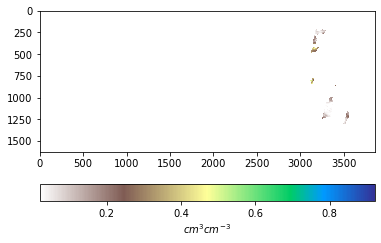

In [48]:
sm_data[sm_data==f[group_id][var_id].attrs['_FillValue']]=np.nan;
plt.imshow(sm_data,cmap = 'terrain_r');
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('$cm^3 cm^{-3}$')

#### Below we load the EASE2 grid lon and lat datasets. These can be found on the NSIDC website.

In [40]:
# Read binary files and reshape to correct size

lats = np.fromfile(os.path.join(data_dir, 'EASE2_M09km.lats.3856x1624x1.double'), 
                      dtype=np.float64).reshape((1624, 3856))#< reshape to dimensions above
lons = np.fromfile(os.path.join(data_dir, 'EASE2_M09km.lons.3856x1624x1.double'), 
                      dtype=np.float64).reshape((1624, 3856))

# lats = np.fromfile(os.path.join(data_dir, 'EASE2_M36km.lats.964x406x1.double'), 
#                       dtype=np.float64).reshape((406,964))#< reshape to dimensions above
# lons = np.fromfile(os.path.join(data_dir, 'EASE2_M36km.lons.964x406x1.double'), 
#                       dtype=np.float64).reshape((406,964))

#### Isolate Colorado

In [52]:
N_lat = 41.003444
S_lat = 36.992426
W_lon = -109.060253
E_lon = -102.041524

subset = (lats < N_lat) & (lats > S_lat) & (lons > W_lon) & (lons < E_lon)
sm_co = sm_data[subset]
sm_co.shape

(3300,)

In [61]:
# Bounding box taken from https://anthonylouisdagostino.com/bounding-boxes-for-all-us-states/
# Reference for isolating a region: https://gis.stackexchange.com/questions/261061/extract-value-for-a-given-coordinate-from-hdf5-file
box_lat = [36.992426, 41.003444]
box_lon = [-109.060253, -102.041524]


lat_index = np.logical_and(lats > box_lat[0], lats < box_lat[1])
lon_index = np.logical_and(lons > box_lon[0], lons < box_lon[1])
box_index = np.logical_and(lat_index, lon_index)
data = sm_data[box_index]

box_index.shape


ValueError: cannot reshape array of size 3300 into shape (1624,3856)

TypeError: Invalid shape (209,) for image data

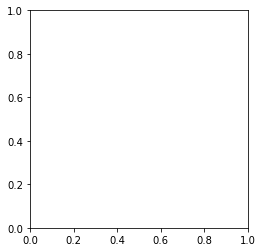

In [23]:
# Plot the data
plt.imshow(data, cmap='coolwarm_r')
plt.title(os.path.basename(file))
cbar = plt.colorbar(orientation = 'horizontal')
cbar.set_label('$cm^3 cm^{-3}$')
plt.axis('off')